# Modeling Notebook

In [5]:
# Import the required libraries
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
import string
import wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import pandas as pd
import numpy as np
from PIL import Image
from os import path

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

np.random.seed(42)


In [31]:
# Any Function Definitions Go HERE

def get_train_test_datasets(dfs, col_names, train_frac, test_frac):
    # Get train and test datasets, consisting of ids, tweet text, and sentiment
    train_dataset = pd.DataFrame()
    test_dataset = pd.DataFrame()
    for df in dfs:
        train_dataset = train_dataset.append(get_random_sample(df, train_frac)[col_names], ignore_index = True)
        test_dataset = test_dataset.append(get_random_sample(df, test_frac)[col_names], ignore_index = True)
    return train_dataset, test_dataset


def get_random_sample(df_to_use, frac_to_use):
    # Randomly select a specified fraction of the total number of rows.
    return df_to_use.sample(frac=frac_to_use)  # ex: df.sample(frac=0.50)


def get_stopwords_list():
    # Get English stopwords, punctuation, and 'empty text' signifiers (like empty quotes and ...)
    return stopwords.words('english')  + list(string.punctuation) + ["''", '""', '...', '``']


def tokenize_tweet(tweet):
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tweet_tokenizer.tokenize(tweet)
    #TODO: any stemming you might want to do
    return tokens


def process_tweet_text_encode_to_ascii(tweet, stopwords_list):
    #tokenize, lowercase each token, remove stopwords
    stopwords_removed = ''
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    try:
        tweet_encode = tweet.encode("ascii", "ignore")
        tweet_decode = tweet_encode.decode()
        tokens = tweet_tokenizer.tokenize(tweet_decode)
        #print(tokens)
        stopwords_removed = [token for token in tokens if token not in stopwords_list]
    except:
        print('Could not encode/decode ', tweet )
    return stopwords_removed

def plot_word_cloud(text, word_max, stopwords_list, bg_color='black'):
    cloud = wordcloud.WordCloud(background_color=bg_color, 
                            min_word_length=2,
                            max_words=word_max)
    cloud.generate(text)
    
    # plot it
    plt.figure(figsize=(15,10))
    plt.imshow(cloud, interpolation='bilinear') 
    plt.axis("off")
    plt.show()


#TODO: figure out why this is not working to apply the image as mask
def plot_word_cloud_with_mask(text, word_max, stopwords_list, bg_color='black'):
    # get data directory (using getcwd() is needed to support running example in generated IPython notebook)
    d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
    twitter_mask = np.array(Image.open('../images/twitter.png'))
    cloud = wordcloud.WordCloud(background_color=bg_color, 
                            min_word_length=2,
                            mask=twitter_mask,
                            contour_width=3, 
                            contour_color='steelblue',
                            max_words=word_max)
    cloud.generate(text)

    # store to file
    cloud.to_file(path.join(d, "twitter_cloud.png"))

    # plot it
    #plt.figure(figsize=(15,10))
    plt.imshow(cloud, interpolation='bilinear') 
    plt.axis("off")
    plt.imshow(twitter_mask, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()


# stopwords for social media
social_media_stopwords = stopwords.words('english')  + ['rt', 'link', '&'] + list(string.punctuation) + ["''", '""', '..', '...', '``']



In [7]:
# read in the processed data
pos_tweets = pd.read_csv('../data/cleaned_tweets_positive.csv', encoding = 'unicode_escape')
print(pos_tweets.shape)
display(pos_tweets.head(1))

neg_tweets = pd.read_csv('../data/cleaned_tweets_negative.csv', encoding = 'unicode_escape')
print(neg_tweets.shape)
display(neg_tweets.head(1))

neutral_tweets = pd.read_csv('../data/cleaned_tweets_neutral.csv', encoding = 'unicode_escape')
print(neutral_tweets.shape)
display(neutral_tweets.head(1))

(2861, 7)


,id,tweet_text,labeled_brand_or_product,detected_emotion,sentiment,brand,tweet_char_count
0,1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Positive,Apple,139


(544, 7)


,id,tweet_text,labeled_brand_or_product,detected_emotion,sentiment,brand,tweet_char_count
0,0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Negative,Apple,127


(5293, 7)


,id,tweet_text,labeled_brand_or_product,detected_emotion,sentiment,brand,tweet_char_count
0,5,@teachntech00 New iPad Apps For #SpeechTherapy...,UNKNOWN,No emotion toward brand or product,Neutral,Apple,140


## Corpus Exploration
* What are the most common words found in Positive, Negative and Neutral Tweets?

In [8]:
# Create word clouds of the most common words in Positive, Negative (and Neutral) Tweets

positive_tweet_words = list()
for tweet in pos_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, social_media_stopwords)
    for word in processed_tweet:
        positive_tweet_words.append(word)

negative_tweet_words = list()
for tweet in neg_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, social_media_stopwords)
    for word in processed_tweet:
        negative_tweet_words.append(word)

neutral_tweet_words = list()
for tweet in neutral_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, social_media_stopwords)
    for word in processed_tweet:
        neutral_tweet_words.append(word)


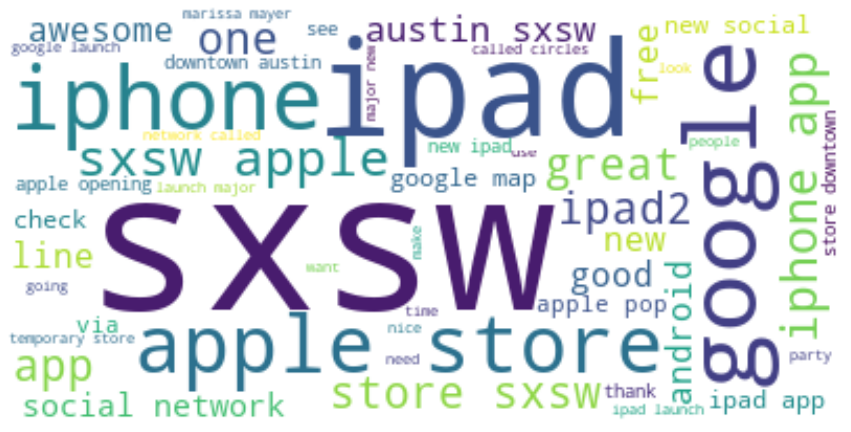

In [9]:
# Postive Tweets top 50 words
positive_text = ' '.join(word for word in positive_tweet_words)
plot_word_cloud(positive_text, 50, social_media_stopwords, 'white')

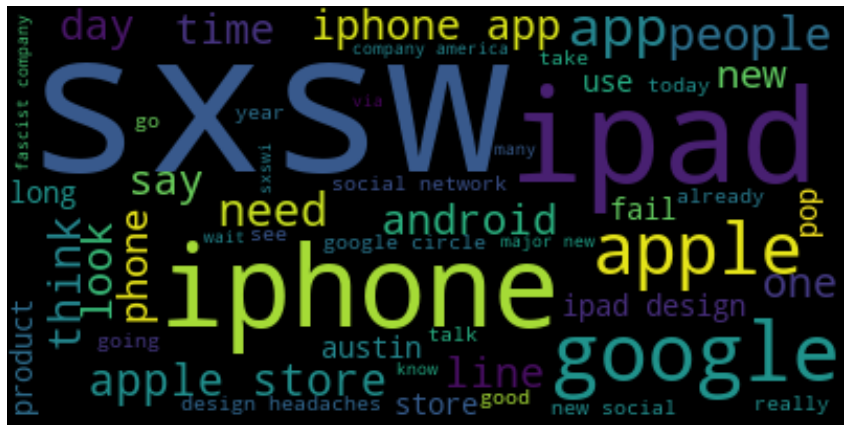

In [10]:
# Negative Tweets top 50 words
negative_text = ' '.join(word for word in negative_tweet_words)
plot_word_cloud(negative_text, 50, social_media_stopwords)

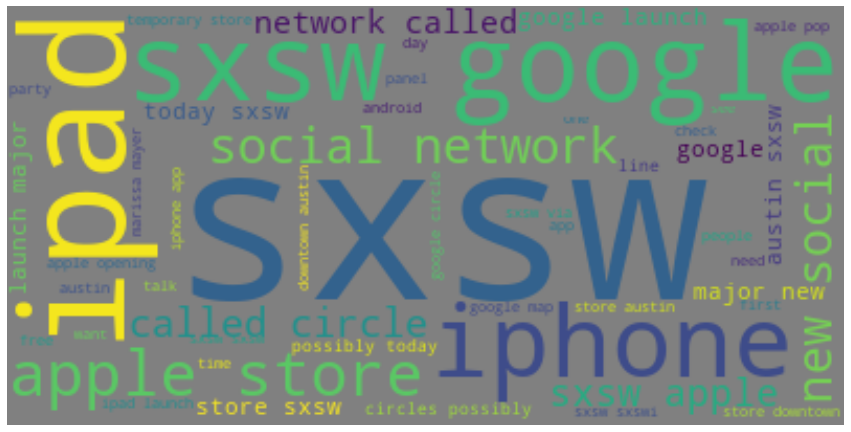

In [11]:
# Neutral Tweets top 50 words
neutral_text = ' '.join(word for word in neutral_tweet_words)
plot_word_cloud(neutral_text, 50, social_media_stopwords, 'grey')

## Text Processing for Classification Model

In [12]:
##
# - Create TRAIN and TEST data sets from the Postive and Negative Tweet datasets.
# - Separate the data (tweet_text) and the labels (sentiment) in both TRAIN and TEST
# - Process the TRAIN tweets
# - Explore TRAIN data with Freq Dist
# - Vectorize TRAIN with sklearn
# - Create a basic model (try MultinomialNB and RandomForestClassifier )
# - Fit each to our vectorized training data
# - Create predictions for TRAIN and TEST sets
# - Calculate the accuracy_score() for both TRAIN and TEST 
# - Experiment with model tuning AND/OR other model choices
#
# TODO decide the best peformance measure, accuracy or precision. What makes sense from a business POV?

In [13]:
# Create TRAIN and TEST datasets
train_df, test_df = get_train_test_datasets([pos_tweets, neg_tweets], ['id', 'tweet_text', 'sentiment'], 0.8, 0.2)


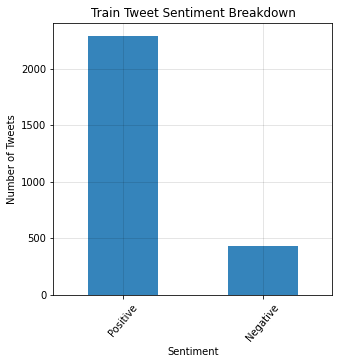

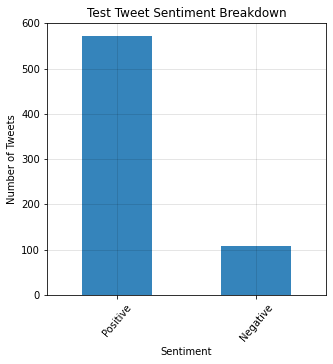

In [14]:
# Let's take a peek at how many tweets of each class are in TRAIN and TEST
train_by_sentiment = train_df.groupby(['sentiment'])['tweet_text'].count()
train_by_sentiment.sort_values(ascending=False, inplace=True)
train_by_sentiment.plot.bar(fontsize=10, rot=50, alpha = 0.90, figsize=(5,5),  title='Train Tweet Sentiment Breakdown')
plt.grid(color = 'black', alpha = 0.1, linestyle = '-', linewidth = 1)
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()


test_by_sentiment = test_df.groupby(['sentiment'])['tweet_text'].count()
test_by_sentiment.sort_values(ascending=False, inplace=True)
test_by_sentiment.plot.bar(fontsize=10, rot=50, alpha = 0.90, figsize=(5,5),  title='Test Tweet Sentiment Breakdown')
plt.grid(color = 'black', alpha = 0.1, linestyle = '-', linewidth = 1)
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()
#TODO: put these in one chart

In [15]:
# Get TRAIN and TEST data and target and prep for processing steps
# TRAIN
train_data = train_df['tweet_text'].to_list()
train_target = train_df['sentiment'].to_list()
# TEST
test_data = test_df['tweet_text'].to_list()
test_target = test_df['sentiment'].to_list()


In [32]:
# Text Processing - TF-IDF
# Use TF_IDF to focus on words that appear heavily in tweets from a given class, but rarely appear in tweets from other class/classes.

from sklearn.feature_extraction.text import TfidfVectorizer

# Use tokenzer for tweets and the customized stopwords list
vectorizer = TfidfVectorizer(tokenizer=tokenize_tweet, stop_words=social_media_stopwords, decode_error='ignore')

# Fit on TRAIN data
tf_idf_data_train = vectorizer.fit_transform(train_data)
# Creat a vectorized version of the TEST data
tf_idf_data_test = vectorizer.transform(test_data)

In [34]:
# TF-IDF - Let's see which terms were important
idf = vectorizer.idf_

feature_weights_dict = dict(zip(vectorizer.get_feature_names(), idf))

sorted_idf = sorted(feature_weights_dict.items(), key=lambda x: x[1], reverse=True)

print(sorted_idf[0:50])

[('#10', 8.217076526537399), ('#100tc', 8.217076526537399), ('#16162', 8.217076526537399), ('#1990style', 8.217076526537399), ('#310409h2011', 8.217076526537399), ('#4sq', 8.217076526537399), ("#4sq's", 8.217076526537399), ('#accessibility', 8.217076526537399), ('#accordion', 8.217076526537399), ('#actors', 8.217076526537399), ('#adam', 8.217076526537399), ('#addictedtotheinterwebs', 8.217076526537399), ('#adpeopleproblems', 8.217076526537399), ('#agnerd', 8.217076526537399), ('#allhat', 8.217076526537399), ('#allhat3', 8.217076526537399), ('#alwayshavingtoplugin', 8.217076526537399), ('#amateurhour', 8.217076526537399), ('#amex', 8.217076526537399), ('#amismarternow', 8.217076526537399), ("#android's", 8.217076526537399), ('#angrybirds', 8.217076526537399), ('#annoying', 8.217076526537399), ('#anybodywanttobuymeanipad2', 8.217076526537399), ('#appcircus', 8.217076526537399), ("#apple's", 8.217076526537399), ('#appleaddiction', 8.217076526537399), ('#appletakingoverworld', 8.2170765265

In [35]:
# Model creation
# create some models and fit them to our vectorized training data
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators=100)


In [36]:
nb_classifier.fit(tf_idf_data_train, train_target)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [37]:
nb_train_score = accuracy_score(train_target, nb_train_preds)
nb_test_score = accuracy_score(test_target, nb_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.8598 		 Testing Accuracy: 0.859


In [38]:
rf_classifier.fit(tf_idf_data_train, train_target)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

In [39]:
rf_train_score = accuracy_score(train_target, rf_train_preds)
rf_test_score = accuracy_score(test_target, rf_test_preds)

print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Random Forest
Training Accuracy: 0.9982 		 Testing Accuracy: 0.9677


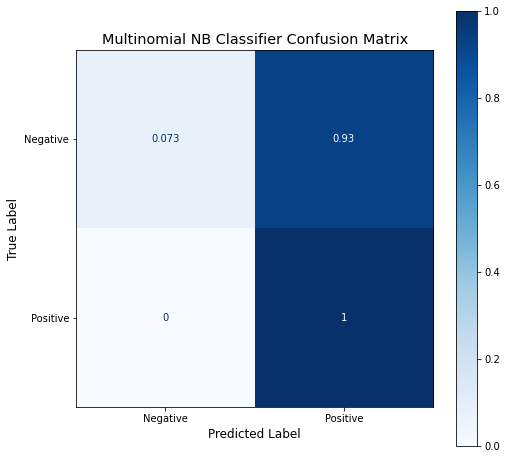

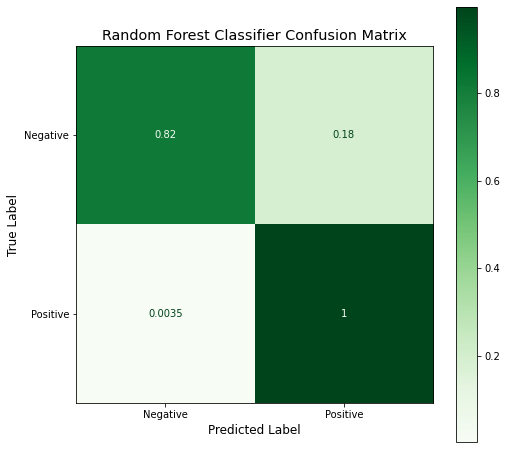

In [368]:
from sklearn.metrics import plot_confusion_matrix

def plot_pretty_cf(predictor, xtest, ytest, cmap='Blues', normalize='true', title=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(predictor, xtest, ytest, cmap=cmap, normalize=normalize, ax=ax)
    ax.set_title(title, size='x-large')
    ax.set_xlabel('Predicted Label', size='large')
    ax.set_ylabel('True Label', size='large')
    plt.show()

plot_pretty_cf(nb_classifier, tf_idf_data_test, test_target, title='Multinomial NB Classifier Confusion Matrix')
plot_pretty_cf(rf_classifier, tf_idf_data_test, test_target, cmap='Greens', title='Random Forest Classifier Confusion Matrix')

In [ ]:
#TODO: Mix in the Neutral tweets 